<a href="https://colab.research.google.com/github/YuliaLoburets/ML_learning/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import LabelEncoder,  label_binarize
import joblib
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
drive.mount('/content/drive', force_remount=True)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Mounted at /content/drive


In [163]:
raw_df = pd.read_csv('drive/MyDrive/ML/NLP/train.csv')
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [164]:
raw_df.shape

(27481, 4)

In [165]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [166]:
raw_df.isna().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [167]:
raw_df.dropna(inplace=True)

In [169]:
raw_df.shape

(27480, 4)

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [170]:
raw_df['sentiment'].value_counts().astype('str') + " (" + raw_df['sentiment'].value_counts(normalize=True).mul(100).round(0).astype('str') + "%)"

,0
sentiment,
neutral,11117 (40.0%)
positive,8582 (31.0%)
negative,7781 (28.0%)


Text(0.5, 1.0, 'Sentiment distribution')

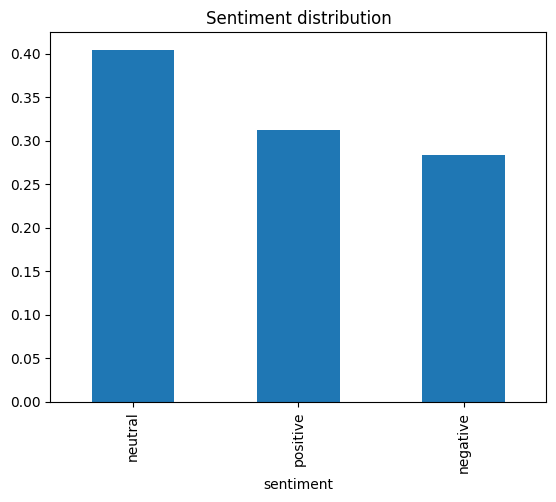

In [171]:
raw_df['sentiment'].value_counts(normalize=True).plot(kind='bar')
plt.title('Sentiment distribution')

Згідно графіку бачимо, що найбільша кількість коментарів є нейтральними. Але в цілому розподіл коментарів за семантикою є більш-менш збалансованим.

In [172]:
raw_df['length'] = raw_df['text'].apply(lambda x: len(x))

Text(0.5, 1.0, 'Distribution of length of words')

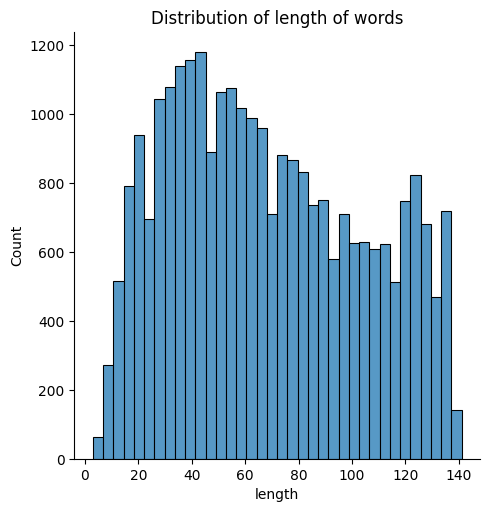

In [173]:
sns.displot(data=raw_df, x='length')
plt.title('Distribution of length of words')

Згідно графіку бачимо, що найбільше коментарів довжиною від 20 до 60 символів. Також є велика кількість тексту довжиною від 120 до 130 символів.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [174]:
stemmer = SnowballStemmer('english')


def reduce_repeated_letters(word):
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def remove_urls(text):
    return re.sub(r'http[s]?://\S+', '', text)

In [175]:
def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # залишити лише слова
    tokens = [reduce_repeated_letters(t) for t in tokens]  # зменшити повторення букв
    tokens = [remove_urls(t) for t in tokens] #прибираємо url адрес
    tokens = [stemmer.stem(t) for t in tokens]  # стемінг
    return tokens

english_stopwords = stopwords.words('english') + ['http', 'url']
vect= CountVectorizer(max_features=5000, lowercase=True, tokenizer=tokenize, stop_words=english_stopwords)
X_inputs = vect.fit_transform(raw_df['text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


In [176]:
X_inputs.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [177]:
X_inputs[0].toarray()[0][0:300]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [178]:
print(vect.get_feature_names_out()[:100])

['aa' 'aah' 'aahh' 'aargh' 'aaron' 'aarrgghh' 'aaw' 'aaww' 'ab' 'abandon'
 'abbi' 'abil' 'abit' 'abl' 'abov' 'absolut' 'abt' 'abus' 'ac' 'academi'
 'accept' 'access' 'accid' 'accident' 'accomplish' 'accord' 'account'
 'acct' 'ace' 'ach' 'achiev' 'acid' 'ack' 'across' 'act' 'action' 'activ'
 'actor' 'actress' 'actual' 'ad' 'adam' 'add' 'addict' 'addit' 'address'
 'admir' 'admit' 'adopt' 'ador' 'adult' 'advanc' 'advantag' 'adventur'
 'advert' 'advertis' 'advic' 'affect' 'afford' 'afraid' 'africa'
 'afternoon' 'afterward' 'age' 'agent' 'agh' 'ago' 'agre' 'ah' 'aha'
 'ahah' 'ahaha' 'ahahaha' 'ahead' 'ahh' 'aidan' 'aiden' 'aight' 'aim'
 'aint' 'air' 'airlin' 'airport' 'aka' 'ako' 'al' 'ala' 'alarm' 'alaska'
 'album' 'alcohol' 'alex' 'alexi' 'algebra' 'ali' 'alic' 'alien' 'alik'
 'aliv' 'allah']


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [179]:
le = LabelEncoder()
y_encoded = le.fit_transform(raw_df['sentiment'])

In [180]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_inputs, y_encoded, test_size=0.3, random_state=42)

In [181]:
model_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [182]:
model_logistic.fit(X_train_bow,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial')

In [183]:
print(model_logistic.classes_)

[0 1 2]


In [184]:
train_pred = model_logistic.predict_proba(X_train_bow)
train_pred

array([[0.13435889, 0.77446457, 0.09117654],
       [0.5863966 , 0.27224153, 0.14136187],
       [0.18499817, 0.55360022, 0.26140161],
       ...,
       [0.07165022, 0.75398835, 0.17436143],
       [0.21760806, 0.59251786, 0.18987408],
       [0.02380398, 0.14007202, 0.836124  ]])

In [185]:
auc = roc_auc_score(y_train, train_pred , multi_class='ovr')
print(f"AUC: {auc:.2f}")

AUC: 0.94


In [186]:
test_pred = model_logistic.predict_proba(X_test_bow)

auc = roc_auc_score(y_test, test_pred , multi_class='ovr')
print(f"AUC: {auc:.2f}")

AUC: 0.83


В цілому модель логістичної регресії дала непоганий результат згідно значення AUROC - на тестовий даних значення 0.83. Але модель є трохи перенавченою, так як значення AUROC значно падає на тестових даних у порівнянні з тренувальними.

##XGBOOST

In [187]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

In [188]:
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])

In [189]:
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    n_estimators=70,
    max_depth = 7,
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_bow, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:23:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=70,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [190]:
train_preds = xgb_model.predict_proba(X_train_bow)
test_preds =  xgb_model.predict_proba(X_test_bow)

In [191]:
auc_train = roc_auc_score(y_train, train_preds , multi_class='ovr')
print(f"AUC for training data: {auc_train:.2f}")
auc_test = roc_auc_score(y_test, test_preds , multi_class='ovr')
print(f"AUC for testing data: {auc_test:.2f}")

AUC for training data: 0.89
AUC for testing data: 0.84


In [ ]:
pred_class_1 = np.argmax(test_preds, axis=1)

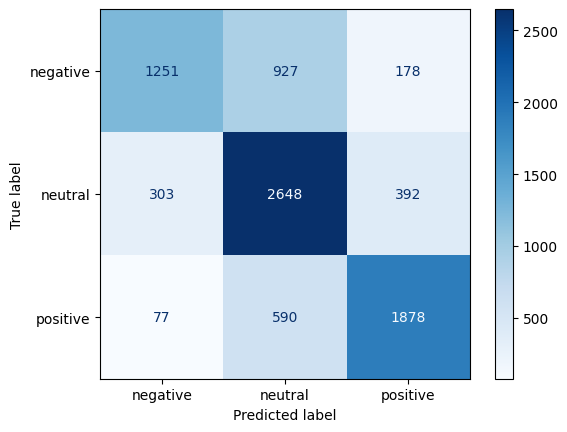

In [ ]:
pred_class_1 = np.argmax(test_preds, axis=1)
cm_1 = confusion_matrix(y_test, pred_class_1)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=le.classes_)
disp_1.plot(cmap='Blues')

In [ ]:
print("Accuracy:", accuracy_score(y_test, pred_class_1))
print(classification_report(y_test, pred_class_1, target_names=le.classes_))

Accuracy: 0.7007520621057739
              precision    recall  f1-score   support

    negative       0.77      0.53      0.63      2356
     neutral       0.64      0.79      0.71      3343
    positive       0.77      0.74      0.75      2545

    accuracy                           0.70      8244
   macro avg       0.72      0.69      0.70      8244
weighted avg       0.71      0.70      0.70      8244



Побудувавши просту модель XGBOOST без підбору гіперпараметрів , значення AUROC становить 0.84 на тестувальний даних. Дещо краще, ніж при логістичній регресії. Також різниця між значенням AUROC на тренувальних та тестувальних даних меньша, ніж при логістичній регресії. Також згідно класифікаційного репорту визначено, що негативний клас має найнижчий recall (0.53), тобто модель не зовсім добре справляється з прогнозуванням негативних текстів. Нейтральний клас має високий recall (0.79), але зменшений precision (0.64), що означає, що модель передбачає нейтральні тексти, але допускає більше помилок. Позитивний клас знаходиться в хорошому балансі з точністю та повнотою (precision і recall близькі).

Попробую тепер побудувати модель XGBOOST за допомогою підбору параметрів.

In [ ]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

In [ ]:
best_auc = [0]

def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1,
        **params
    )

    model.fit(X_train_bow, y_train,
        verbose=False)
    y_proba = model.predict_proba(X_test_bow)


    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')


    if auc > best_auc[0]:
        best_auc[0] = auc
        joblib.dump(model, 'best_xgb_model_auc.pkl')

    return {'loss': -auc, 'status': STATUS_OK}

In [ ]:
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)
print("Найкращі гіперпараметри: ", best)
print(f"Найкращий AUROC: {best_auc[0]:.2f}")

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:10:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  2%|▏         | 1/50 [00:26<21:21, 26.15s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:11:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  4%|▍         | 2/50 [00:34<12:39, 15.83s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:11:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  6%|▌         | 3/50 [00:47<11:17, 14.41s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:11:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  8%|▊         | 4/50 [01:00<10:37, 13.86s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:11:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 5/50 [01:06<08:19, 11.09s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:11:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█▏        | 6/50 [01:08<05:52,  8.01s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:11:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 14%|█▍        | 7/50 [01:21<06:57,  9.70s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 16%|█▌        | 8/50 [01:27<05:57,  8.50s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 18%|█▊        | 9/50 [01:33<05:14,  7.68s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 10/50 [01:35<03:49,  5.73s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 22%|██▏       | 11/50 [01:44<04:25,  6.80s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 24%|██▍       | 12/50 [01:48<03:50,  6.06s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 26%|██▌       | 13/50 [01:57<04:18,  6.99s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 28%|██▊       | 14/50 [02:06<04:34,  7.63s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 15/50 [02:16<04:52,  8.36s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 32%|███▏      | 16/50 [02:24<04:36,  8.14s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 34%|███▍      | 17/50 [02:30<04:03,  7.38s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 36%|███▌      | 18/50 [02:37<03:52,  7.25s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 19/50 [02:44<03:45,  7.29s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 20/50 [02:53<03:52,  7.74s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 42%|████▏     | 21/50 [03:05<04:22,  9.04s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 44%|████▍     | 22/50 [03:19<04:56, 10.58s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 46%|████▌     | 23/50 [03:33<05:16, 11.71s/trial, best loss: -0.8475514259019737]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 48%|████▊     | 24/50 [03:47<05:22, 12.40s/trial, best loss: -0.8483017734896556]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 25/50 [03:52<04:15, 10.20s/trial, best loss: -0.8483017734896556]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 52%|█████▏    | 26/50 [04:06<04:30, 11.25s/trial, best loss: -0.8483017734896556]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 54%|█████▍    | 27/50 [04:29<05:40, 14.79s/trial, best loss: -0.8483017734896556]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:15:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 56%|█████▌    | 28/50 [04:46<05:37, 15.36s/trial, best loss: -0.8483017734896556]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:15:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 58%|█████▊    | 29/50 [04:48<04:01, 11.52s/trial, best loss: -0.8483017734896556]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:15:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 30/50 [05:11<04:57, 14.87s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:16:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 62%|██████▏   | 31/50 [05:24<04:28, 14.12s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:16:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 64%|██████▍   | 32/50 [05:40<04:25, 14.73s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:16:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 66%|██████▌   | 33/50 [05:51<03:53, 13.74s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:16:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 68%|██████▊   | 34/50 [06:06<03:46, 14.13s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:16:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 35/50 [06:19<03:24, 13.65s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:17:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 72%|███████▏  | 36/50 [06:34<03:17, 14.08s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:17:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 74%|███████▍  | 37/50 [06:47<03:00, 13.88s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:17:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 76%|███████▌  | 38/50 [06:52<02:12, 11.06s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:17:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 78%|███████▊  | 39/50 [07:03<02:01, 11.01s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:17:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 40/50 [07:17<02:00, 12.05s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:18:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 82%|████████▏ | 41/50 [07:25<01:37, 10.80s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:18:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 84%|████████▍ | 42/50 [07:35<01:25, 10.67s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:18:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 86%|████████▌ | 43/50 [07:43<01:07,  9.70s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:18:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 88%|████████▊ | 44/50 [08:06<01:22, 13.68s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:18:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 45/50 [08:23<01:14, 14.84s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 92%|█████████▏| 46/50 [08:29<00:48, 12.04s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 94%|█████████▍| 47/50 [08:33<00:28,  9.64s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 96%|█████████▌| 48/50 [08:48<00:22, 11.37s/trial, best loss: -0.8489007427797776]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 98%|█████████▊| 49/50 [08:59<00:11, 11.22s/trial, best loss: -0.8489628219979529]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 50/50 [09:10<00:00, 11.01s/trial, best loss: -0.8489628219979529]
Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.9137820222519613), 'gamma': np.float64(0.3404019907138658), 'learning_rate': np.float64(0.18345370450684437), 'max_depth': np.float64(10.0), 'min_child_weight': np.float64(2.0), 'n_estimators': np.float64(230.0), 'reg_alpha': np.float64(0.3250206457737297), 'reg_lambda': np.float64(0.38939194836608193), 'subsample': np.float64(0.7610646353827613)}
Найкращий AUROC: 0.85


In [ ]:
final_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    min_child_weight =  int(best['min_child_weight']),
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    device='cuda'
)

final_clf.fit(X_train_bow, y_train)
final_pred_train = final_clf.predict_proba(X_train_bow)
final_pred_test = final_clf.predict_proba(X_test_bow)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:22:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:22:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:22:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
auc_train_xg = roc_auc_score(y_train, final_pred_train , multi_class='ovr')
print(f"AUC for training data: {auc_train_xg:.2f}")
auc_test_xg = roc_auc_score(y_test, final_pred_test , multi_class='ovr')
print(f"AUC for testing data: {auc_test_xg:.2f}")

AUC for training data: 0.92
AUC for testing data: 0.85


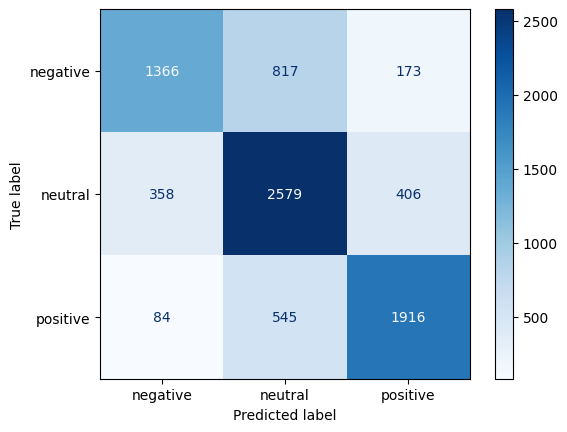

In [ ]:
pred_class_2 = np.argmax(final_pred_test, axis=1)
cm_2 = confusion_matrix(y_test, pred_class_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=le.classes_)
disp_2.plot(cmap='Blues')

In [ ]:
print("Accuracy:", accuracy_score(y_test, pred_class_2))
print(classification_report(y_test, pred_class_2, target_names=le.classes_))

Accuracy: 0.7109412906356137
              precision    recall  f1-score   support

    negative       0.76      0.58      0.66      2356
     neutral       0.65      0.77      0.71      3343
    positive       0.77      0.75      0.76      2545

    accuracy                           0.71      8244
   macro avg       0.73      0.70      0.71      8244
weighted avg       0.72      0.71      0.71      8244



Після підбору параметрів модель значення AUROC трохи покращилось на тестувальних даних у порівнянні з попередньою моделлю.
Точність accuracy зросла до 71%. Негативний клас все ще має помірний recall (0.58), тобто є місце для покращення в прогнозуванні негативних текстів.Нейтральний клас має гарний recall (0.77), але є деякі помилки в точності (65%).Позитивний клас має гарний баланс між precision і recall, з результатами 0.75 та 0.77.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


##Most important words

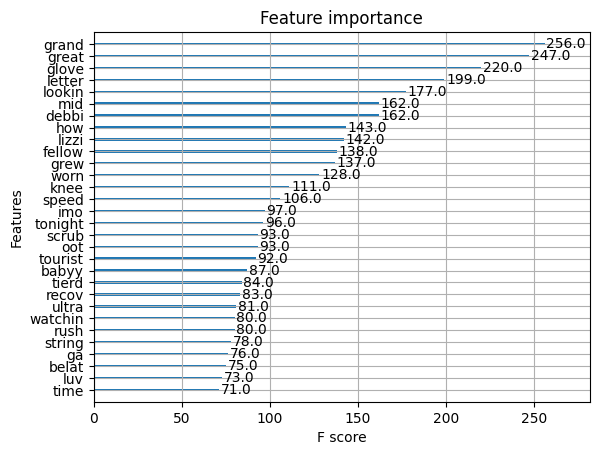

In [ ]:
booster = final_clf.get_booster()
feature_names = vectorizer.get_feature_names_out()
booster.feature_names = feature_names.tolist()
xgb.plot_importance(booster, importance_type='weight', max_num_features=30)
plt.show()

In [ ]:
importance = final_clf.get_booster().get_score(importance_type='weight')
important_words_ = sorted(importance.items(), key=lambda x: x[1], reverse=True)

for word, score in important_words_[:100]:
    print(f"Word: {word}, Importance: {score}")

Word: grand, Importance: 256.0
Word: great, Importance: 247.0
Word: glove, Importance: 220.0
Word: letter, Importance: 199.0
Word: lookin, Importance: 177.0
Word: debbi, Importance: 162.0
Word: mid, Importance: 162.0
Word: how, Importance: 143.0
Word: lizzi, Importance: 142.0
Word: fellow, Importance: 138.0
Word: grew, Importance: 137.0
Word: worn, Importance: 128.0
Word: knee, Importance: 111.0
Word: speed, Importance: 106.0
Word: imo, Importance: 97.0
Word: tonight, Importance: 96.0
Word: oot, Importance: 93.0
Word: scrub, Importance: 93.0
Word: tourist, Importance: 92.0
Word: babyy, Importance: 87.0
Word: tierd, Importance: 84.0
Word: recov, Importance: 83.0
Word: ultra, Importance: 81.0
Word: rush, Importance: 80.0
Word: watchin, Importance: 80.0
Word: string, Importance: 78.0
Word: ga, Importance: 76.0
Word: belat, Importance: 75.0
Word: luv, Importance: 73.0
Word: ay, Importance: 71.0
Word: time, Importance: 71.0
Word: throat, Importance: 69.0
Word: headach, Importance: 67.0
Word

## Less important words

In [ ]:
importance = final_clf.get_booster().get_score(importance_type='weight')
important_words_ = sorted(importance.items(), key=lambda x: x[1], reverse=False)

for word, score in important_words_[:100]:
    print(f"Word: {word}, Importance: {score}")

Word: absolut, Importance: 1.0
Word: accomplish, Importance: 1.0
Word: agenc, Importance: 1.0
Word: ah, Importance: 1.0
Word: ahahaha, Importance: 1.0
Word: allah, Importance: 1.0
Word: amsterdam, Importance: 1.0
Word: answer, Importance: 1.0
Word: anywher, Importance: 1.0
Word: arghh, Importance: 1.0
Word: argument, Importance: 1.0
Word: asham, Importance: 1.0
Word: atleast, Importance: 1.0
Word: attic, Importance: 1.0
Word: auto, Importance: 1.0
Word: awesome, Importance: 1.0
Word: awhil, Importance: 1.0
Word: awsom, Importance: 1.0
Word: bamboozl, Importance: 1.0
Word: barri, Importance: 1.0
Word: bash, Importance: 1.0
Word: bass, Importance: 1.0
Word: bat, Importance: 1.0
Word: bedtim, Importance: 1.0
Word: blade, Importance: 1.0
Word: blair, Importance: 1.0
Word: blanket, Importance: 1.0
Word: bleh, Importance: 1.0
Word: boost, Importance: 1.0
Word: bride, Importance: 1.0
Word: brought, Importance: 1.0
Word: bugger, Importance: 1.0
Word: bummer, Importance: 1.0
Word: cake, Importa

В цілому бачу, що є багато слів, які з аналітичної точки зору не повинні мати високу значимість, але мають високий рівень, такі як how, luv, imo, debbi, ga.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [ ]:
vectorizer_tf = TfidfVectorizer(max_features=5000, lowercase=True, tokenizer=tokenize, stop_words=english_stopwords)
tfidf_matrix = vectorizer_tf.fit_transform(raw_df['text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_tf.get_feature_names_out()).round(2)
tfidf_df.head()

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


,aa,aah,aahh,aargh,aaron,aarrgghh,aaw,aaww,ab,abandon,...,zack,ze,zealand,zelda,zero,zoe,zombi,zone,zoo,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_tf, X_test_tf, y_train, y_test, texts_train, texts_test = train_test_split(
    tfidf_df, y_encoded, raw_df[['text','sentiment']], test_size=0.3, random_state=42)

In [ ]:
xgb_model_tf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    min_child_weight =  int(best['min_child_weight']),
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    device='cuda'
)

In [ ]:
xgb_model_tf.fit(X_train_tf, y_train)
preds_train_tf = xgb_model_tf.predict_proba(X_train_tf)
preds_test_tf = xgb_model_tf.predict_proba(X_test_tf)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:30:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:30:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:30:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
auc_train_tf = roc_auc_score(y_train, preds_train_tf , multi_class='ovr')
print(f"AUC for training data: {auc_train_tf:.2f}")
auc_test_tf = roc_auc_score(y_test, preds_test_tf , multi_class='ovr')
print(f"AUC for testing data: {auc_test_tf:.2f}")

AUC for training data: 0.93
AUC for testing data: 0.85


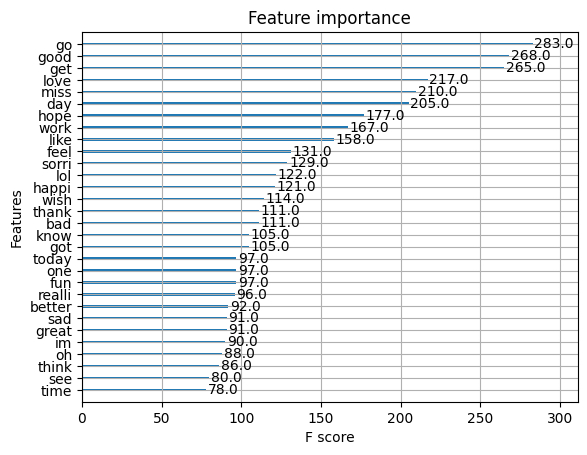

In [ ]:
booster_tf = xgb_model_tf.get_booster()
feature_names_tf = vectorizer_tf.get_feature_names_out()
booster_tf.feature_names = feature_names_tf.tolist()
xgb.plot_importance(booster_tf, importance_type='weight', max_num_features=30)
plt.show()

Виходячи з результатів метрики AUC, значення на тестовому наборі даних залишилось незмінним і становить 0.85 у порівнянні з моделлю, яка вчиться на датасеті Bag of Words. В цьому випадку, немає значного поліпшення моделі. Але список слів , які мають вплив, є більш логічним, ніж з векторизатором bag of words, тому для фінальної моделі я би обрала TF-IDF.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [ ]:
pred_class = np.argmax(preds_test_tf, axis=1)

In [ ]:
texts_test['pred_class'] = pred_class

In [ ]:
code_to_label = {i: label for i, label in enumerate(le.classes_)}
code_to_label

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [ ]:
texts_test['pred_class'] = texts_test['pred_class'].map(code_to_label)

In [ ]:
texts_test['error'] = texts_test.apply(lambda row: False if row['pred_class'] != row['sentiment'] else True, axis=1)

In [ ]:
texts_test['error'].value_counts(normalize=True)

,proportion
error,
True,0.706089
False,0.293911


In [ ]:
texts_test[texts_test['error'] == False].head(50)

,text,sentiment,pred_class,error
10414,--of them kinda turns me off of it all. And ...,negative,neutral,False
580,OHSHNAPSSS. is she pissed at blair as usual ?...,neutral,negative,False
25014,oooh sounds yummy. If you get a chance to ta...,positive,neutral,False
6718,At work... What a miserable day,negative,neutral,False
2831,I wish I had company,negative,positive,False
21210,i`m on my mobile so it won`t let me but i ca...,negative,neutral,False
11029,I wish I could go. See ya at Warped for sure...,positive,neutral,False
16793,Intel gfx driver situation much better with re...,negative,neutral,False
4891,xD hello that`s an important date!,positive,neutral,False
10882,. Well gotdamn girl!!! I dont know what else!!...,neutral,negative,False


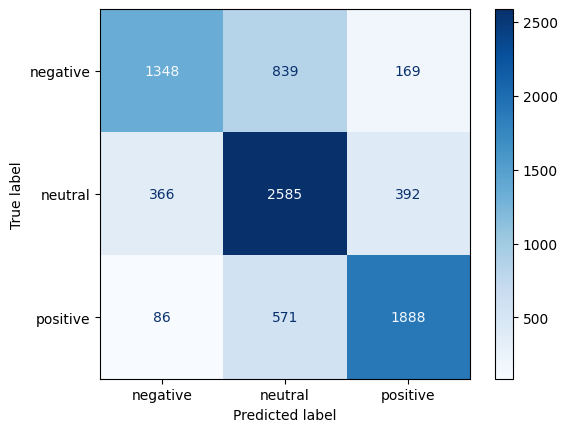

In [ ]:
cm = confusion_matrix(y_test, pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')

In [ ]:
print("Accuracy:", accuracy_score(y_test, pred_class))
print(classification_report(y_test, pred_class, target_names=le.classes_))

Accuracy: 0.7060892770499757
              precision    recall  f1-score   support

    negative       0.75      0.57      0.65      2356
     neutral       0.65      0.77      0.70      3343
    positive       0.77      0.74      0.76      2545

    accuracy                           0.71      8244
   macro avg       0.72      0.70      0.70      8244
weighted avg       0.71      0.71      0.70      8244



Згідно таблиці ,бачимо, що Accuracy 0.70 — модель правильна на 70% всіх випадків.

Precision (точність):

 - Negative: 0.75 — з усіх передбачених негативних класів 75% справжні.
 - Neutral: 0.65 — з усіх передбачених нейтральних 65% справжні.
 - Positive: 0.77 — з усіх передбачених позитивних 77% справжні.

Recall (повнота):

- Negative: 0.57 — лише 57% усіх справжніх негативних випадків було правильно передбачено.
- Neutral: 0.77 — 77% усіх справжніх нейтральних випадків було правильно передбачено.
- Positive: 0.74 — 74% усіх справжніх позитивних випадків було правильно передбачено.

F1-score:

Загалом непогані значення, особливо для позитивних і нейтральних класів, але негативний клас має низьку recall (0.57), що вказує на те, що модель не дуже добре справляється з передбаченням негативних текстів.

Для покращення якості класифікації можна спробувати:
1) застосувати методи балансування класів, зробити негативний клас більш вагомим, так як модель найчастіше помиляється саме на ньому.
2) попрацювати ще над обробкою слів та прибрати слова, які не несуть в собі контексту
3) спробувати зменшити розмірність даних за допомогою PCA
4) попробувати застосувати інші моделі як LightGBM або Random Forest.
5) можливо ще спробувати зменшити кількість важливих слів у векторизаторі, щоб було меньше шуму

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model